# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import scipy.stats as stat
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

sns.set()

# Reading the Data

In [2]:
X_train_backup = pd.read_csv('X_train.csv')
X_test_backup = pd.read_csv('X_test.csv')

y_train_backup = pd.read_csv('y_train.csv', header=None, names=['Index', 'loan_status:Not_Default'])
y_test_backup = pd.read_csv('y_test.csv', header=None, names=['Index', 'loan_status:Not_Default'])

In [3]:
X_train = X_train_backup.set_index('Unnamed: 0')
X_test = X_test_backup.set_index('Unnamed: 0')

y_train = y_train_backup.set_index('Index')
y_test = y_test_backup.set_index('Index')

# Loading Pre-Trained Model

In [4]:
filename = 'init_logistic_regression_model.sav'
log_reg_init_model = pickle.load(open(filename, 'rb'))

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Initial Predictions

In [5]:
pre_predictions = log_reg_init_model.predict(X_test)
print("Error Rate")
print((np.where(pre_predictions==y_test['loan_status:Not_Default'], 0, 1).sum() / len(y_test)) * 100, end=' ')
print("%")

Error Rate
12.61550779193779 %


In [6]:
pre_proba = log_reg_init_model.predict_proba(X_test)
pre_predictions_proba = np.where(pre_proba[:, 1]>=0.5, 1, 0)
print("Error Rate")
print((np.where(pre_predictions_proba==y_test['loan_status:Not_Default'], 0, 1).sum() / len(y_test)) * 100, end=' ')
print("%")

Error Rate
12.61550779193779 %


# Evaluating Model Performance (F1 Score)

In [7]:
tp = np.where(((y_test['loan_status:Not_Default']==1) & (pre_predictions==1)), 1, 0).sum()
tn = np.where(((y_test['loan_status:Not_Default']==0) & (pre_predictions==0)), 1, 0).sum()
fp = np.where(((y_test['loan_status:Not_Default']==1) & (pre_predictions==0)), 1, 0).sum()
fn = np.where(((y_test['loan_status:Not_Default']==0) & (pre_predictions==1)), 1, 0).sum()

F1_df = pd.DataFrame(index=['Predicted:1', 'Predicted:0'], columns=['Actual:1', 'Actual:0'])
F1_df.at['Predicted:1', 'Actual:1'] = tp
F1_df.at['Predicted:0', 'Actual:0'] = tn
F1_df.at['Predicted:0', 'Actual:1'] = fp
F1_df.at['Predicted:1', 'Actual:0'] = fn
F1_df

,Actual:1,Actual:0
Predicted:1,394616,56586
Predicted:0,453,479


In [8]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1 = (2*precision*recall) / (precision+recall)
print("F1 Score at Threshold = 0.5 is: "+str(F1))

F1 Score at Threshold = 0.5 is: 0.9325996046183787


# AUROC Curve

In [9]:
y_pred_proba = log_reg_init_model.predict_proba(X_test)[:, 1]
y_true = y_test['loan_status:Not_Default']

In [10]:
benchmark_pred = [0 for _ in range(0, len(y_true))]

benchmark_auc = roc_auc_score(y_true, benchmark_pred)
log_reg_auc = roc_auc_score(y_true, y_pred_proba)

print("Benchmark Predictions AUC - %0.4f" % benchmark_auc)
print("Model Predictions AUC - %0.4f" % log_reg_auc)

Benchmark Predictions AUC - 0.5000
Model Predictions AUC - 0.7518


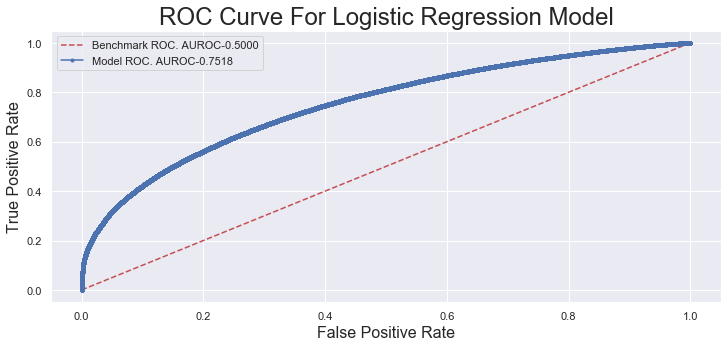

In [11]:
benchmark_fpr, benchmark_tpr, _ = roc_curve(y_true, benchmark_pred)
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_true, y_pred_proba)

plt.figure(figsize = (12, 5))
plt.plot(benchmark_fpr, benchmark_tpr, linestyle='--', color='r', label='Benchmark ROC. AUROC-%0.4f'%benchmark_auc)
plt.plot(log_reg_fpr, log_reg_tpr, marker='.', color='b', label='Model ROC. AUROC-%0.4f'%log_reg_auc)

plt.title('ROC Curve For Logistic Regression Model', size=24)
plt.xlabel('False Positive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)

plt.legend()
plt.show()

# Selecting Best Thresholds

In [24]:
def find_fpr_tpr(t, y_pred_proba, y_true):
    y_pred = np.where(y_pred_proba>=t, 1, 0)
    
    tp = np.where(((y_pred==1) & (y_true==1)), 1, 0).sum()
    tn = np.where(((y_pred==0) & (y_true==0)), 1, 0).sum()
    fp = np.where(((y_pred==0) & (y_true==1)), 1, 0).sum()
    fn = np.where(((y_pred==1) & (y_true==0)), 1, 0).sum()
    
    fpr = fp/(tn+fp)
    tpr = tp/(tp+fn)
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F1 = (2*precision*recall) / (precision+recall)
    
    F1_df = pd.DataFrame(index=['Predicted:1', 'Predicted:0'], columns=['Actual:1', 'Actual:0'])
    F1_df.at['Predicted:1', 'Actual:1'] = tp
    F1_df.at['Predicted:0', 'Actual:0'] = tn
    F1_df.at['Predicted:0', 'Actual:1'] = fp
    F1_df.at['Predicted:1', 'Actual:0'] = fn
    
    print()
    print()
    
    print("For Threshold = "+str(t))
    print(F1_df)
    print("FPR: %0.4f" % fpr, end='\t')
    print("TPR: %0.4f" % tpr)
    print("F1 Score = "+str(F1))
    
    return fpr, tpr, F1

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':




For Threshold = 0
            Actual:1 Actual:0
Predicted:1   395069    57065
Predicted:0        0        0
FPR: nan	TPR: 0.8738
F1 Score = 0.9326430619343888


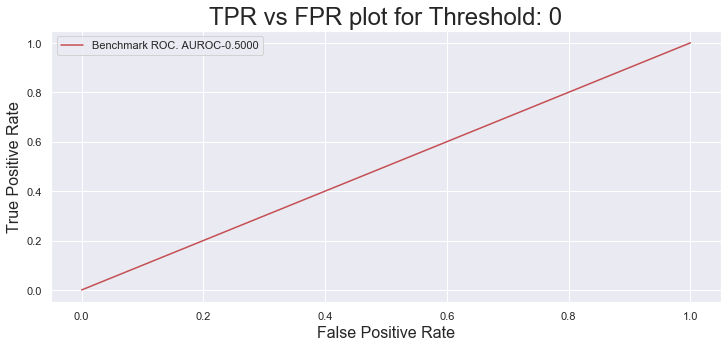



For Threshold = 0.1
            Actual:1 Actual:0
Predicted:1   395069    57065
Predicted:0        0        0
FPR: nan	TPR: 0.8738
F1 Score = 0.9326430619343888


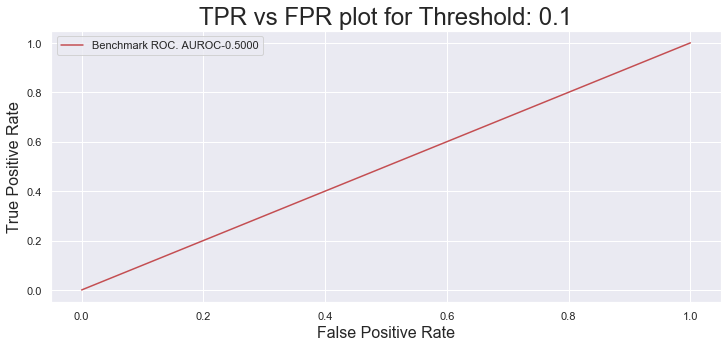



For Threshold = 0.2
            Actual:1 Actual:0
Predicted:1   395069    57065
Predicted:0        0        0
FPR: nan	TPR: 0.8738
F1 Score = 0.9326430619343888


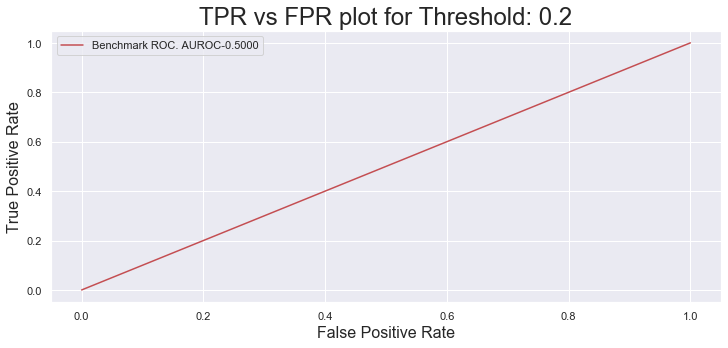



For Threshold = 0.3
            Actual:1 Actual:0
Predicted:1   395069    57065
Predicted:0        0        0
FPR: nan	TPR: 0.8738
F1 Score = 0.9326430619343888


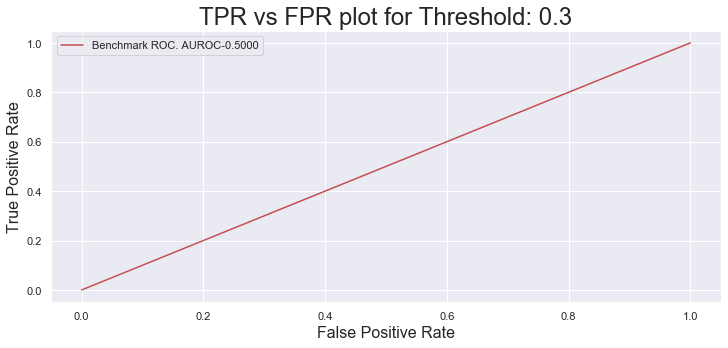



For Threshold = 0.4
            Actual:1 Actual:0
Predicted:1   395061    57049
Predicted:0        8       16
FPR: 0.3333	TPR: 0.8738
F1 Score = 0.9326505968632367


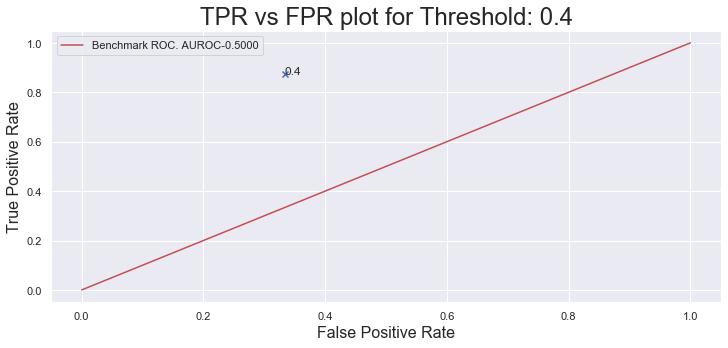



For Threshold = 0.5
            Actual:1 Actual:0
Predicted:1   394616    56586
Predicted:0      453      479
FPR: 0.4861	TPR: 0.8746
F1 Score = 0.9325996046183787


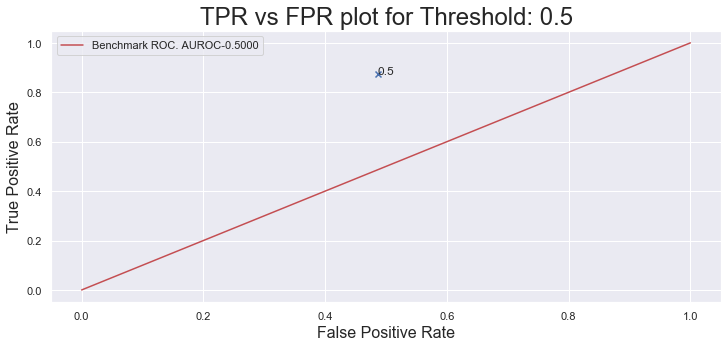



For Threshold = 0.6
            Actual:1 Actual:0
Predicted:1   390798    53659
Predicted:0     4271     3406
FPR: 0.5563	TPR: 0.8793
F1 Score = 0.9309967767525962


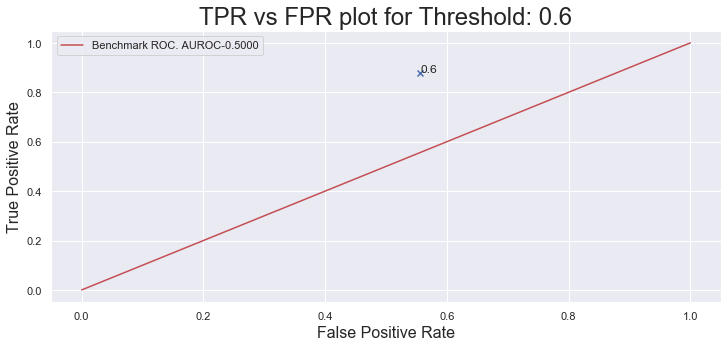



For Threshold = 0.7
            Actual:1 Actual:0
Predicted:1   374461    45376
Predicted:0    20608    11689
FPR: 0.6381	TPR: 0.8919
F1 Score = 0.9190286977884565


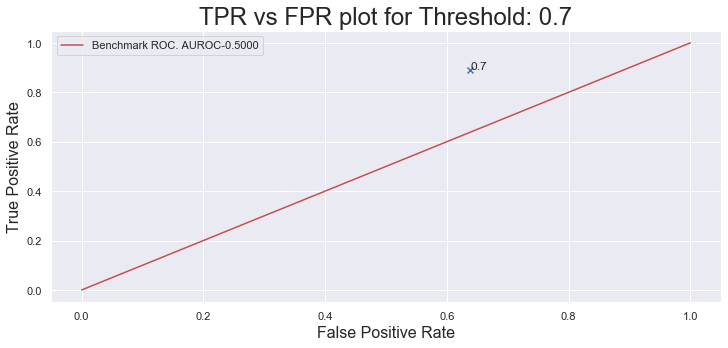



For Threshold = 0.8
            Actual:1 Actual:0
Predicted:1   326189    29880
Predicted:0    68880    27185
FPR: 0.7170	TPR: 0.9161
F1 Score = 0.8685194997457192


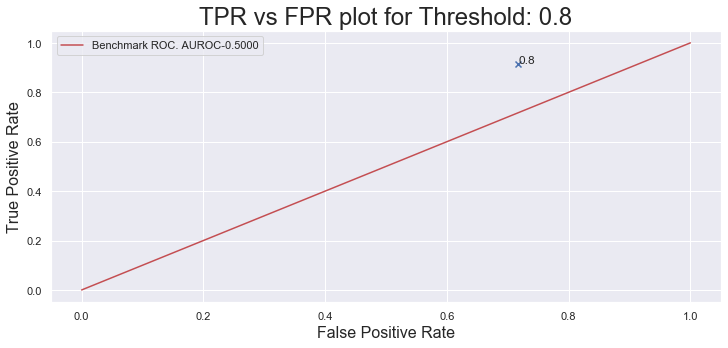



For Threshold = 0.9
            Actual:1 Actual:0
Predicted:1   208728     9834
Predicted:0   186341    47231
FPR: 0.7978	TPR: 0.9550
F1 Score = 0.6803046130329139


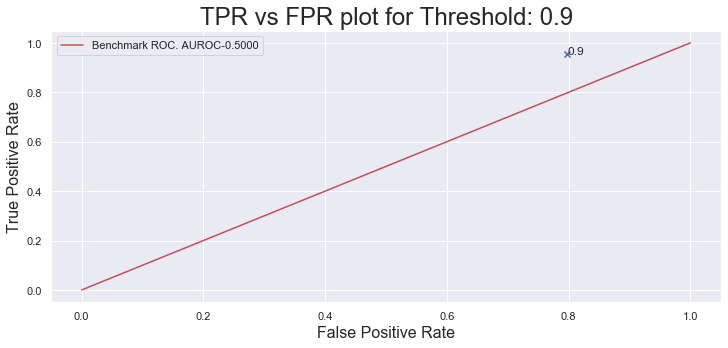

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]




For Threshold = 1
            Actual:1 Actual:0
Predicted:1        0        0
Predicted:0   395069    57065
FPR: 0.8738	TPR: nan
F1 Score = nan


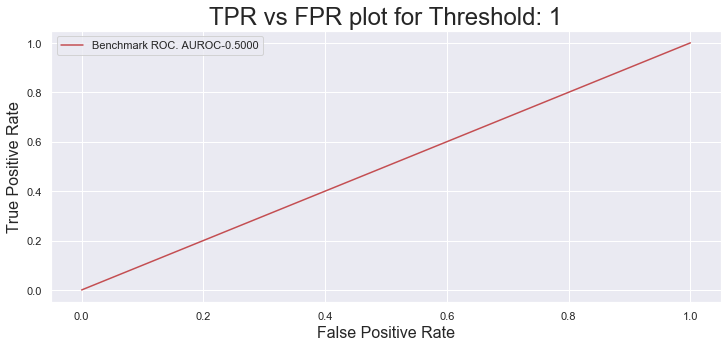

In [25]:
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
fpr_list = list()
tpr_list = list()
F1_list = list()

benchmark_pred = [0 for _ in range(0, len(y_true))]
y_true = y_test['loan_status:Not_Default']
y_pred_proba = log_reg_init_model.predict_proba(X_test)[:, 1]

for i, t in enumerate(thresholds):
    fpr, tpr, F1 = find_fpr_tpr(t, y_pred_proba, y_true)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    F1_list.append(F1)
    
    benchmark_fpr, benchmark_tpr, _ = roc_curve(y_true, benchmark_pred)
    log_reg_fpr, log_reg_tpr, _ = roc_curve(y_true, y_pred_proba)

    plt.figure(figsize = (12, 5))
    plt.scatter(fpr, tpr, marker='x')
    plt.annotate(t, (fpr, tpr))
    plt.plot(benchmark_fpr, benchmark_tpr, linestyle='-', color='r', label='Benchmark ROC. AUROC-%0.4f'%benchmark_auc)

    plt.title('TPR vs FPR plot for Threshold: '+str(t), size=24)
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)

    plt.legend()
    plt.show()

Depending on the requirements for FPR and TPR, the thresholds can be chosen. For this project, the default threshold of 0.5 is chosen

# Evaluating Model Performance

### Gini Graph

In [26]:
gini_df = y_test.copy()
gini_df['loan_status:Default'] = np.where(gini_df['loan_status:Not_Default']==1, 0, 1)

gini_df['Predicted_Proba'] = log_reg_init_model.predict_proba(X_test)[:, 1]
gini_df = gini_df.sort_values(by='Predicted_Proba')
gini_df = gini_df.reset_index()

gini_df['Cumulative_Pop'] = (gini_df.index + 1)
gini_df['Cumulative_Good'] = gini_df['loan_status:Not_Default'].cumsum()
gini_df['Cumulative_Bad'] = gini_df['loan_status:Default'].cumsum()

gini_df['Cumulative_Pop_Percent'] = gini_df['Cumulative_Pop'] / gini_df['Cumulative_Pop'].values[-1]
gini_df['Cumulative_Good_Percent'] = gini_df['Cumulative_Good'] / gini_df['Cumulative_Good'].values[-1]
gini_df['Cumulative_Bad_Percent'] = gini_df['Cumulative_Bad'] / gini_df['Cumulative_Bad'].values[-1]

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


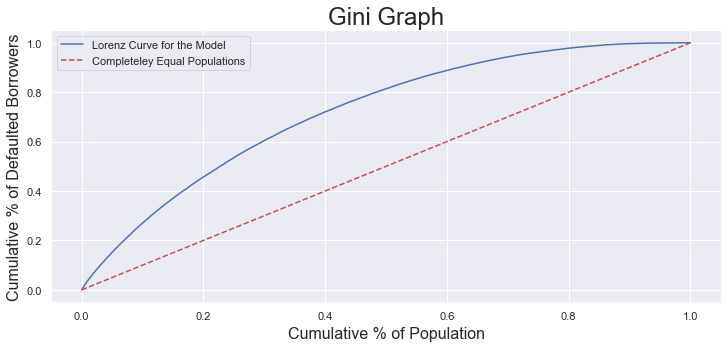

In [27]:
plt.figure(figsize = (12, 5))

plt.plot(gini_df['Cumulative_Pop_Percent'], gini_df['Cumulative_Bad_Percent'], color='b', label='Lorenz Curve for the Model')
plt.plot(gini_df['Cumulative_Pop_Percent'], gini_df['Cumulative_Pop_Percent'], linestyle='--', color='r', label='Completeley Equal Populations')

plt.title('Gini Graph', size=24)
plt.xlabel('Cumulative % of Population', size=16)
plt.ylabel('Cumulative % of Defaulted Borrowers', size=16)

plt.legend()
plt.show()

In [28]:
log_reg_auc = roc_auc_score(gini_df['loan_status:Not_Default'], gini_df['Predicted_Proba'])
gini_coefficient = (log_reg_auc*2) -1
print("Gini Coefficient: %0.4f" % gini_coefficient)

Gini Coefficient: 0.5036


### KS Graph

In [29]:
ks_df = gini_df.copy()

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


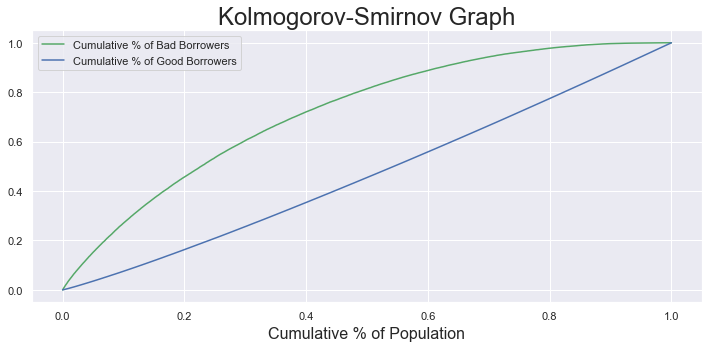

In [30]:
plt.figure(figsize = (12, 5))

plt.plot(ks_df['Cumulative_Pop_Percent'], ks_df['Cumulative_Bad_Percent'], color='g', label='Cumulative % of Bad Borrowers')
plt.plot(ks_df['Cumulative_Pop_Percent'], ks_df['Cumulative_Good_Percent'], color='b', label='Cumulative % of Good Borrowers')

plt.title('Kolmogorov-Smirnov Graph', size=24)
plt.xlabel('Cumulative % of Population', size=16)

plt.legend()
plt.show()

In [31]:
print("KS Statistic")
print(ks_2samp(ks_df['Cumulative_Good_Percent'], ks_df['Cumulative_Bad_Percent']))

KS Statistic
Ks_2sampResult(statistic=0.35184259533678064, pvalue=0.0)


In [32]:
print("Manually Computed KS Statistic - %0.4f" % abs(ks_df['Cumulative_Good_Percent'] - ks_df['Cumulative_Bad_Percent']).max())

Manually Computed KS Statistic - 0.3670
